Imports Libraries

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

import keras_tuner as kt

Data Preparation

In [7]:
def load_and_preprocess_images(directory, image_size=(224, 224)):
    images = []
    labels = []
    paths = []
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png"):
                img_path = os.path.join(subdir, file)
                image = cv2.imread(img_path)
                if image is not None:
                    image = cv2.resize(image, image_size)
                    image = image / 255.0  # Normalize
                    images.append(image)
                    labels.append(subdir.split(os.sep)[-2])  # Use the parent directory as label
                    paths.append(img_path)
    return np.array(images), labels, paths

# Load images from the provided dataset directory
dataset_dir = 'train'  # Specify your dataset directory here
images, labels, image_paths = load_and_preprocess_images(dataset_dir)
print(f"Loaded {len(images)} images from the dataset.")

Loaded 201 images from the dataset.


Define the Model Building Function

In [8]:
def build_model(hp, num_classes):
    inputs = Input(shape=(224, 224, 3))
    x = Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32), 
               kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(filters=hp.Int('conv_2_filter', min_value=64, max_value=256, step=64), 
               kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu')(x)
    x = Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1))(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Hyperparameter Tuning

In [ ]:
# Prepare data for training
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Number of classes
num_classes = len(np.unique(labels))

# Initialize the tuner
tuner = kt.RandomSearch(
    hypermodel=lambda hp: build_model(hp, num_classes),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='kt_dir',
    project_name='furniture_tuning'
)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = build_model(best_hps, num_classes)

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Feature Extraction

In [10]:
# Ensure the model is built by calling it with some input data
model.predict(np.expand_dims(images[0], axis=0))

# Create a model to extract features from the penultimate layer
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

# Extract features for the entire dataset
features = feature_extractor.predict(images)
print(f"Extracted features for {len(features)} images.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 551ms/step
Extracted features for 201 images.


Calculate Similarities

In [15]:
def find_similar_images(input_image_path, model, features, image_paths, top_n=10):
    input_image = cv2.imread(input_image_path)
    input_image = cv2.resize(input_image, (224, 224)) / 255.0
    input_image = np.expand_dims(input_image, axis=0)
    
    input_features = model.predict(input_image)
    
    similarities = cosine_similarity(input_features, features)
    similar_indices = np.argsort(similarities[0])[::-1][:top_n]
    
    similar_images = [image_paths[idx] for idx in similar_indices]
    return similar_images

# Example usage
input_image_path = 'test-pic2.jpeg'
similar_images = find_similar_images(input_image_path, feature_extractor, features, image_paths)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Recommend Similar Images

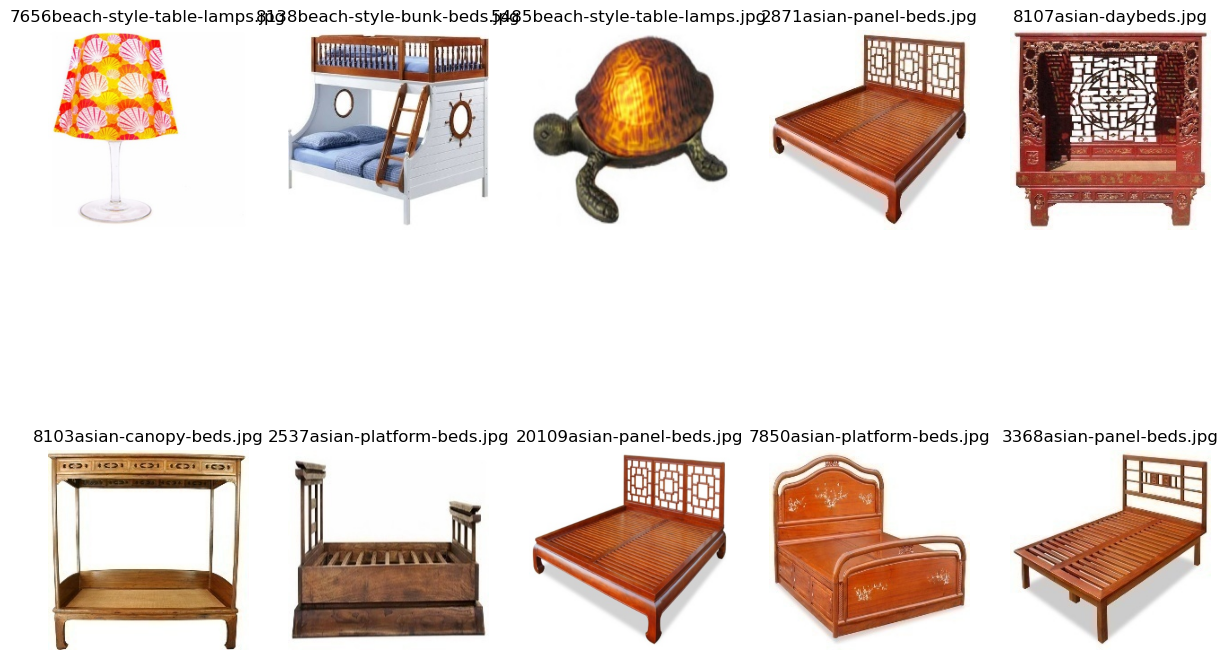

In [16]:
def display_images(image_paths):
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(os.path.basename(img_path))
    plt.show()

# Display similar images
display_images(similar_images)

In [3]:
Try to run with Test data

In [ ]:
# Prepare data for training
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Number of classes
num_classes = len(np.unique(labels))

# Initialize the tuner
tuner = kt.RandomSearch(
    hypermodel=lambda hp: build_model(hp, num_classes),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='kt_dir',
    project_name='furniture_tuning'
)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = build_model(best_hps, num_classes)

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Reloading Tuner from kt_dir\furniture_tuning\tuner0.json
Epoch 1/20


E:\Old Files\Machine Learning\New folder\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
E:\Old Files\Machine Learning\New folder\Lib\site-packages\keras\src\losses\losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 110s 6s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 113s 7s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 109s 6s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 109s 6s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/20
11/17 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 1.0000 - loss: 0.0000e+00

In [ ]:
# Ensure the model is built by calling it with some input data
model.predict(np.expand_dims(images[0], axis=0))

# Create a model to extract features from the penultimate layer
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

# Extract features for the entire dataset
features = feature_extractor.predict(images)
print(f"Extracted features for {len(features)} images.")

In [ ]:
def find_similar_images(input_image_path, model, features, image_paths, top_n=10):
    input_image = cv2.imread(input_image_path)
    input_image = cv2.resize(input_image, (224, 224)) / 255.0
    input_image = np.expand_dims(input_image, axis=0)
    
    input_features = model.predict(input_image)
    
    similarities = cosine_similarity(input_features, features)
    similar_indices = np.argsort(similarities[0])[::-1][:top_n]
    
    similar_images = [image_paths[idx] for idx in similar_indices]
    return similar_images

# Example usage
input_image_path = 'test-pic2.jpeg'
similar_images = find_similar_images(input_image_path, feature_extractor, features, image_paths)

In [ ]:
def display_images(image_paths):
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(os.path.basename(img_path))
    plt.show()

# Display similar images
display_images(similar_images)